# Trading Signal Generation

In [2]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE
import os

pd.set_option('display.max_colwidth', None)

## Preprocessing

In [3]:
file_path = "data/processed/labeled_january_data.csv"

with open(file_path, "r", encoding="utf-8") as file:
    df_jan = pd.read_csv(file)

In [4]:
file_path = "data/processed/labeled_february_data.csv"

with open(file_path, "r", encoding="utf-8") as file:
    df_feb = pd.read_csv(file)

In [5]:
import spacy

# spacy PT model
nlp = spacy.load('pt_core_news_sm')

#preprocessing
def preprocess_text_spacy(text):
    doc = nlp(text)
    
    # lemmatization and stopwords removal
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    #tokens back to 1 string
    return ' '.join(tokens)

# preprocess ALL articles in january's dataframe
df_jan['preprocessed_article'] = df_jan['article'].apply(preprocess_text_spacy)
df_feb['preprocessed_article'] = df_feb['article'].apply(preprocess_text_spacy)

## Applying the Word2Vec approach

In [6]:
from gensim.models import Word2Vec

# Prepare tokenized articles
tokenized_articles = df_jan['preprocessed_article'].apply(str.split).tolist() + \
                     df_feb['preprocessed_article'].apply(str.split).tolist()

# Train Word2Vec
word2vec_model = Word2Vec(
    sentences=tokenized_articles,
    vector_size=300,  # Embedding dimensionality
    window=5,         # Context window size
    min_count=5,      # Minimum word frequency
    sg=1,             # Skip-gram method
    workers=4,        # Number of threads
    epochs=20         # Number of training iterations
)

word2vec_model.save("models/w2v.model")

In [7]:
import numpy as np

def vectorize_article(text, model):
    """
    Generate a document vector by averaging word embeddings.
    :param text: Preprocessed article as a string.
    :param model: Trained Word2Vec model.
    :return: Document vector (numpy array).
    """
    tokens = text.split()
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

# Generate embeddings for both datasets
df_jan['embedding'] = df_jan['preprocessed_article'].apply(lambda x: vectorize_article(x, word2vec_model))
df_feb['embedding'] = df_feb['preprocessed_article'].apply(lambda x: vectorize_article(x, word2vec_model))

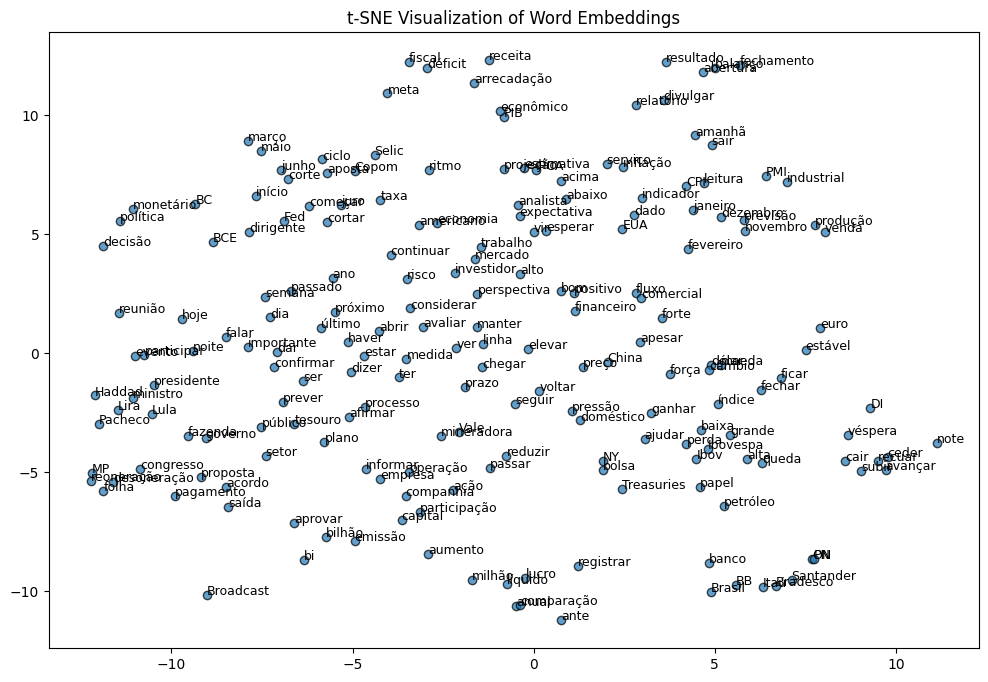

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Get most frequent words
most_frequent_words = word2vec_model.wv.index_to_key[:200]  # Top 200 words
word_vectors = np.array([word2vec_model.wv[word] for word in most_frequent_words])

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_embeddings_2d = tsne.fit_transform(word_vectors)

# Plot t-SNE visualization
plt.figure(figsize=(12, 8))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], alpha=0.7, edgecolors='k')
for i, word in enumerate(most_frequent_words):
    plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]), fontsize=9)
plt.title('t-SNE Visualization of Word Embeddings')
plt.savefig("results/balanced_class/figures/word2vec_tsne_visualization.png")
plt.show()

## Visualising the distribution of the Target variable
- helps us to realize a class imbalance
- good to keep track of
- MOVE THIS INTO the PREPROCESSING file eventually

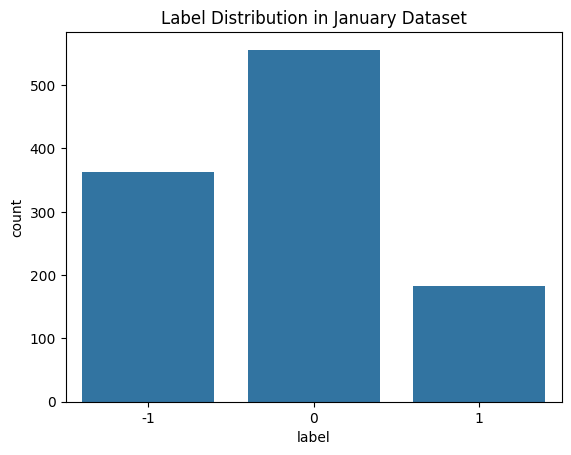

In [9]:
sns.countplot(x='label', data=df_jan)
plt.title('Label Distribution in January Dataset')
plt.savefig("results/balanced_class/figures/label_distribution_january.png")
plt.show()

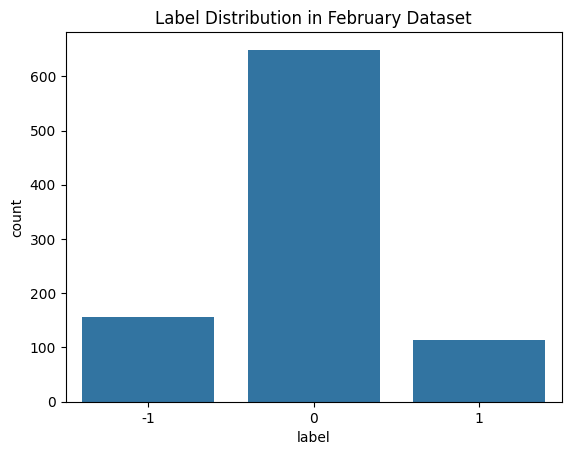

In [10]:
sns.countplot(x='label', data=df_feb)
plt.title('Label Distribution in February Dataset')
plt.savefig("results/balanced_class/figures/label_distribution_february.png")
plt.show()

In [11]:
# January

import pandas as pd

file_path = 'data/processed/labeled_january_data.csv'
jan_dist = pd.read_csv(file_path)

column_data = jan_dist['label']
counts = column_data.value_counts()

count_1 = counts[1]
count_minus_1 = counts[-1]
count_0 = counts[0]

print("January\n")
print(f"Count of 1: {count_1}")
print(f"Count of -1: {count_minus_1}")
print(f"Count of 0: {count_0}")
print(f"Total Number of Articles: {count_1 + count_minus_1 + count_0}")

January

Count of 1: 182
Count of -1: 363
Count of 0: 556
Total Number of Articles: 1101


In [12]:
# February

import pandas as pd

file_path = 'data/processed/labeled_february_data.csv'
feb_dist = pd.read_csv(file_path)

column_name = 'label'
column_data = feb_dist[column_name]

counts = column_data.value_counts()

count_1 = counts[1]
count_minus_1 = counts[-1]
count_0 = counts[0]


print("February\n")
print(f"Count of 1: {count_1}")
print(f"Count of -1: {count_minus_1}")
print(f"Count of 0: {count_0}")
print(f"Total Number of Articles: {count_1 + count_minus_1 + count_0}")

February

Count of 1: 113
Count of -1: 157
Count of 0: 649
Total Number of Articles: 919


## Multinomial Logistic Regression Model with Custom Word2Vec Model

Task: 
- Train on January, test on February
    - Train / test with 3 classes (+1, 0, -1), yielding a 3 x 3 confusion matrix
    - Train / test with 2 classes (+1, -1), yielding a 2 x 2 confusion matrix
- Apply softmax to improve accuracy if poor

In [13]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

c:\Users\scaro\Downloads\pt-br\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Multi-class Classification Report:
               precision    recall  f1-score   support

          -1       0.29      0.55      0.38       157
           0       0.88      0.58      0.70       649
           1       0.20      0.35      0.26       113

    accuracy                           0.54       919
   macro avg       0.46      0.49      0.44       919
weighted avg       0.69      0.54      0.59       919

Multi-class Confusion Matrix:
 [[ 87  28  42]
 [165 374 110]
 [ 50  24  39]]


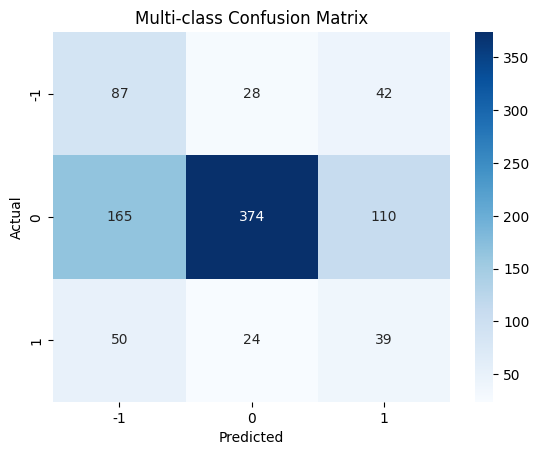

Binary Classification Report:
               precision    recall  f1-score   support

          -1       0.60      0.46      0.52       157
           1       0.43      0.57      0.49       113

    accuracy                           0.51       270
   macro avg       0.52      0.52      0.51       270
weighted avg       0.53      0.51      0.51       270

Binary Confusion Matrix:
 [[73 84]
 [49 64]]


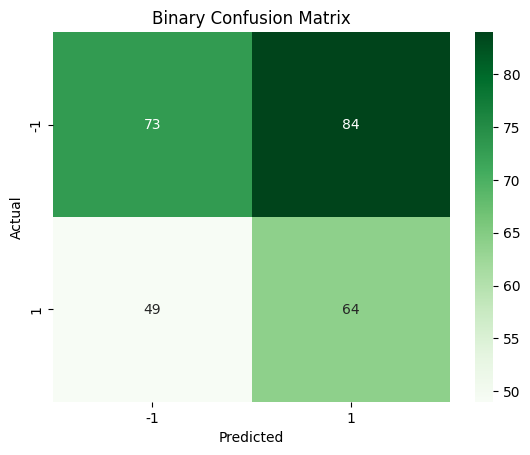

['models/balanced_class/binary_model.pkl']

In [14]:
X_train = np.vstack(df_jan['embedding'].values)
y_train_multi = df_jan['label']  # Multi-class labels
y_train_binary = df_jan['label'].replace(0, -1)  # Binary labels (+1, -1)

# Filter out examples labeled as 0 for binary classification

df_feb_binary = df_feb[df_feb['label'] != 0]
X_test_binary = np.vstack(df_feb_binary['embedding'].values)
y_test_binary = df_feb_binary['label'].replace(0, -1).values  # Ensure consistent length

X_test = np.vstack(df_feb['embedding'].values)
y_test_multi = df_feb['label']

# Multinomial Logistic Regression
from sklearn.linear_model import LogisticRegression
from scipy.special import softmax

multi_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced')
multi_model.fit(X_train, y_train_multi)
multi_preds = multi_model.predict(X_test)

# Binary Logistic Regression
binary_model = LogisticRegression(class_weight='balanced')
binary_model.fit(X_train, y_train_binary)
binary_preds = binary_model.predict(X_test_binary)

# Evaluate multi-class model
print("Multi-class Classification Report:\n", classification_report(y_test_multi, multi_preds))
print("Multi-class Confusion Matrix:\n", confusion_matrix(y_test_multi, multi_preds))

# Plot multi-class confusion matrix
multi_cm = confusion_matrix(y_test_multi, multi_preds)
sns.heatmap(multi_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["-1", "0", "1"], yticklabels=["-1", "0", "1"])
plt.title("Multi-class Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluate binary model
print("Binary Classification Report:\n", classification_report(y_test_binary, binary_preds))
print("Binary Confusion Matrix:\n", confusion_matrix(y_test_binary, binary_preds))

# Plot binary confusion matrix
binary_cm = confusion_matrix(y_test_binary, binary_preds)
sns.heatmap(binary_cm, annot=True, fmt='d', cmap='Greens', xticklabels=["-1", "1"], yticklabels=["-1", "1"])
plt.title("Binary Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save models
joblib.dump(multi_model, 'models/balanced_class/multi_class_model.pkl')
joblib.dump(binary_model, 'models/balanced_class/binary_model.pkl')